In [ ]:
!pip install opencv-contrib-python-nonfree

     |████████████████████████████████| 34.9MB 85kB/s 


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import cv2

In [ ]:
!wget 'http://files.fast.ai/data/cifar10.tgz'
!tar -xf cifar10.tgz

--2020-06-10 06:03:33--  http://files.fast.ai/data/cifar10.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168168549 (160M) [application/x-gtar-compressed]
Saving to: ‘cifar10.tgz’

cifar10.tgz         100%[===================>] 160.38M  36.0MB/s    in 5.0s    

2020-06-10 06:03:39 (32.0 MB/s) - ‘cifar10.tgz’ saved [168168549/168168549]



In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
device = get_device()

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
data_dir = '/content/cifar10'

print(os.listdir(data_dir))
classes = sorted(os.listdir(data_dir + "/train"))
print(classes)

['labels.txt', 'train', 'test']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
data_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor()])
dataset = ImageFolder(data_dir+'/train',   transform=data_transform)

In [ ]:
len(dataset)

50000

In [ ]:
def split_indices(n, val_pct, seed):
    # Determine size of validation set
    n_val = int(val_pct*n)
    # Set the random seed (for reproducibility)
    np.random.seed(seed)
    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [ ]:
val_pct = 0.2
rand_seed = 42

train_indices, val_indices = split_indices(len(dataset), val_pct, rand_seed)
print(len(train_indices), len(val_indices))
print('Sample validation indices: ', val_indices[:10])

40000 10000
Sample validation indices:  [33553  9427   199 12447 39489 42724 10822 49498  4144 36958]


In [ ]:
batch_size=256

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, 
                      batch_size, 
                      sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                    batch_size, 
                    sampler=val_sampler)

Label:  airplane


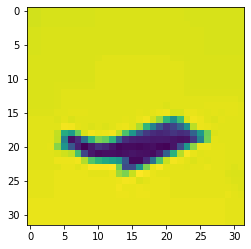

In [ ]:
img,label = dataset[200]
print("Label: ",classes[label])
plt.imshow(np.array(img.squeeze()))


Label:  automobile


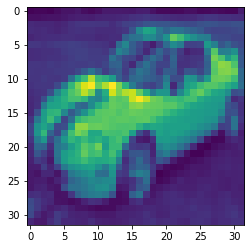

In [ ]:
img,label = dataset[6739]
print("Label: ",classes[label])
plt.imshow(np.array(img.squeeze()))

In [ ]:
def getDescriptor(img,descriptor):
  # descriptor = cv2.xfeatures2d.SIFT_create()
  # arr  = cv2.imread(img) #.permute(1,2,0)
  # print(img.shape)
  # gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
  # arr = np.array(img.squeeze())
  gray= cv2.normalize(np.array(img.squeeze()), None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
  # print(gray)
  #keypt,
  step_size = 8
  kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                      for x in range(0, gray.shape[1], step_size)]
  des = descriptor.compute(gray, kp)
  # des = descriptor.detectAndCompute(gray,None)
  # print(len(des))
  return des

In [ ]:
def genCodebook(descriptors, k):
    # k=int(k)
    iterations = 10
    epsilon = 1.0
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, iterations, epsilon)
    compactness, labels, centers = cv2.kmeans(descriptors, k , None,criteria, iterations, cv2.KMEANS_RANDOM_CENTERS)
    # print(compactness)
    # print('Labels shape: ', labels.shape)
    return labels,centers


In [ ]:
def bowVector(descriptors, centers,klabels):
    count = 0
    vbow = np.array([np.zeros(centers.shape[0]) for i in range(len(descriptors))],dtype = np.float32)
    # nkp = np.size(klabels)
    # print('vbow shape:',vbow.shape)
    for i in range(len(descriptors)):
      l = len(descriptors[i])
      # print('l in vbow: ',l)
      for j in range(l):
        idx = klabels[count+j]
        vbow[i][idx] += 1     #/nkp
      count += l
    # print(vbow)
    return torch.as_tensor(vbow)

In [ ]:
# from numpy import count_nonzero
# def sparsity(vbow):
#   sparsity = 1.0 - ( count_nonzero(vbow) / float(vbow.size) )
#   print(sparsity)

In [ ]:
def accuracy(outputs,labels):
  _,preds =  torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [ ]:
class CifarModel(nn.Module):

  def __init__(self,input_size,hidden_size,out_size,k):
    super().__init__()
    self.k = k
    self.linear1 = nn.Linear(input_size,hidden_size)
    self.linear2 = nn.Linear(hidden_size,out_size)

  def forward(self,vb):
    # vb = vb.view(vb.size(0),-1)
    vb = vb.view(-1,input_size)
    # print('vbow shape:',vb.shape)
    out = self.linear1(vb)
    out = F.relu(out)
    out = self.linear2(out)
    return out

  def training_step(self,batch):
    vbow,labels = prepareBOW(batch,self.k)
    out = self(vbow)
    # print('Out shape:',out.shape)
    # print('labels shape:',labels.shape)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    vbow,labels = prepareBOW(batch,self.k)
    out = self(vbow)
    # print('Out shape:',out.shape)
    # print('labels shape:',labels.shape)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss' : loss, 'val_acc' : acc }

  def validation_epoch_end(self,outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss' : epoch_loss.item(), 'val_acc' : epoch_acc.item() }
    
  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


In [ ]:
def prepareBOW(batch,k=8):
  descriptor = cv2.xfeatures2d.SIFT_create()
  images,labels = batch
  # print('images shape:',images.shape)
  # print('lbls shape:',labels.shape)
  descs = None
  batch_feat = []
  for i in images:
    feat = getDescriptor(i,descriptor)
    kp,d = feat
    # print(len(d))
    batch_feat.append(d)
    # if descs is None:
    #   descs = np.array(d, dtype=np.float32)
    # else:
    #   descs = np.vstack((descs, np.array(d)))
  # print(descs.shape)
  # print(len(batch_feat))
  # klabels, kcentres = genCodebook(descs,k)
  # print('kcentres.shape:',kcentres.shape)
  # print('len(batch_feat):',len(batch_feat))
  # print('Max: {}, Min label:{}'.format(max(klabels),min(labels)))
  # vbow = bowVector(batch_feat,kcentres,klabels)
  # print(vbow[0])
  # print(vbow.size(0))
  # sparsity(vbow)
  vbow=torch.as_tensor(np.array(batch_feat))
  # print(vbow.view(-1,16*128).shape)
  data = (vbow,torch.as_tensor(labels))
  data = to_device(data,device)
  return data


In [ ]:
input_size = 16 * 128
clusters = 16 #same as k
num_classes = len(classes)

model = CifarModel(input_size, hidden_size=128,out_size=num_classes,k=clusters)

to_device(model, device)

CifarModel(
  (linear1): Linear(in_features=2048, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
# for batch in train_dl:
#   d=prepareBOW(batch)
#   break

In [ ]:
def evaluate(model, valid_loader):
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
def fit(model,train_loader,valid_loader,epochs,opt_fn,lr):
  history = []
  opt = opt_fn(model.parameters(),lr)  
  
  for epoch in range(epochs):
    #For Training
    for batch in train_loader:
      loss = model.training_step(batch)
      # print('\n')Adam
      loss.backward()
      opt.step()
      opt.zero_grad()
    
    #For validation
    result = evaluate(model, valid_loader)
    if(epoch+1)%1==0:
      model.epoch_end(epoch+1,result)
    history.append(result)
  return history    


In [ ]:
history = fit(model,train_dl,val_dl,30,torch.optim.SGD,0.0005)

Epoch [1], val_loss: 1.9386, val_acc: 0.2843
Epoch [2], val_loss: 1.8459, val_acc: 0.3213
Epoch [3], val_loss: 1.8030, val_acc: 0.3411
Epoch [4], val_loss: 1.7752, val_acc: 0.3577
Epoch [5], val_loss: 1.7689, val_acc: 0.3695
Epoch [6], val_loss: 1.7174, val_acc: 0.3826
Epoch [7], val_loss: 1.6994, val_acc: 0.3792
Epoch [8], val_loss: 1.6440, val_acc: 0.4033
Epoch [9], val_loss: 1.6480, val_acc: 0.4055
Epoch [10], val_loss: 1.6771, val_acc: 0.3992
Epoch [11], val_loss: 1.7375, val_acc: 0.3945
Epoch [12], val_loss: 1.5890, val_acc: 0.4401
Epoch [13], val_loss: 1.6046, val_acc: 0.4299
Epoch [14], val_loss: 1.5731, val_acc: 0.4380
Epoch [15], val_loss: 1.6136, val_acc: 0.4289
Epoch [16], val_loss: 1.6008, val_acc: 0.4341
Epoch [17], val_loss: 1.5581, val_acc: 0.4450
Epoch [18], val_loss: 1.5913, val_acc: 0.4359
Epoch [19], val_loss: 1.5793, val_acc: 0.4379
Epoch [20], val_loss: 1.5526, val_acc: 0.4485
Epoch [21], val_loss: 1.5452, val_acc: 0.4563
Epoch [22], val_loss: 1.5373, val_acc: 0.45

In [ ]:
torch.save(model.state_dict(),'cifar_sift.pth')

In [ ]:
# model2 = CifarModel()
# model2.load_state_dict(torch.load('cifar_sift.pth'))
# model2.state_dict()

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=data_transform)

In [ ]:
test_dl = DataLoader(test_dataset, batch_size=256)

In [ ]:
test_result = evaluate(model,test_dl)

In [ ]:
print("test_loss: {:.4f}, test_acc: {:.4f}".format(test_result['val_loss'], test_result['val_acc']))

test_loss: 1.5153, test_acc: 0.4752
